In [1]:
import jax 
jax.config.update("jax_enable_x64", True)

import lss_utils
import PT_field

import jax.numpy as jnp
import numpy as np

import matplotlib.pyplot as plt

if jax.config.jax_enable_x64:
    print("Using 64-bit precision.")
    base_dtype = jnp.float64
else:
    print("Using 32-bit precision.")
    base_dtype = jnp.float32


Using 64-bit precision.


In [2]:
root_data = '/fs52/akitsukz/nbody_data/1000/np1536/Gaussian/'

boxsize = 1000
kf = 2 * jnp.pi / boxsize

seed = 1991

#ng = 1024
ng = 512
ng_E = 512

z_ic = 39
z_out = 0.5
snap = 2
OM0 = 0.30964

growth = PT_field.growth_D_f(z_out, OM0)[0] / PT_field.growth_D_f(z_ic, OM0)[0]
growth_f = PT_field.growth_D_f(z_out, OM0)[1]
print(growth, growth_f)

24.18230441693389 0.7568646934498438


In [3]:
ics_1024_k = np.load(f'{root_data}/{seed}/ic/density_1024.npy')
ics_1024_k *= growth

ics_k_jax = PT_field.coord_jax.func_reduce_hermite(ng, jnp.array(ics_1024_k))

In [4]:
ng_L = int(1.5*ng)

window_order = 2
interlace = True

model = PT_field.LPT_Forward(boxsize=boxsize, ng_L=ng_L, ng_E=ng_E,
                             mas_cfg=(window_order, interlace), 
                             rsd=False, lya=False, lpt_order=1, bias_order=3,
                             dtype=base_dtype,
                             )

shifted_fields = model.get_shifted_fields(ics_k_jax, growth_f=growth_f, field_type='scalar')

idx_to_fields = {0:'1',  1:'d',  2:'d2',  3:'G2',
                 4:'d3', 5:'dG2', 6:'G3', 7:'Gamma3'}

In [5]:
k_edges = jnp.linspace(0.0, 0.8, 80)
mu_edges = jnp.array([0.0, 1.0])

measure_pk_E = lss_utils.Measure_Pk(boxsize, ng_E, k_edges, dtype=base_dtype)

k_arr, pks_auto, Nmodes = PT_field.compute_pks_2d(shifted_fields, mu_edges, measure_pk=measure_pk_E)

#pks_auto: (n_fields, Nk, Nmu)

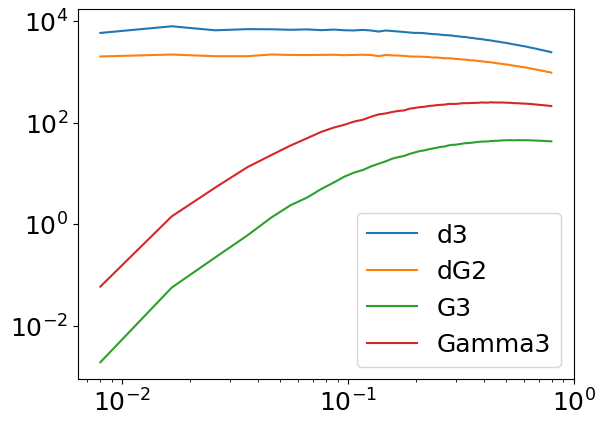

In [33]:
i_field = 0
i_mu = 0
#for i_field in range(len(shifted_fields)):
for i_field in [4,5,6,7]:
    field = idx_to_fields[i_field]
    plt.plot(k_arr, pks_auto[i_field,:,i_mu], label=f'{field}')

#plt.title(mu)
plt.legend()
plt.xscale('log')
plt.yscale('log')

In [7]:
shifted_1, shifted_d, shifted_d2, shifted_G2, shifted_d3, shifted_dG2, shifted_G3, shifted_Gamma3 = shifted_fields


In [8]:
orthogonalized_fields = PT_field.orthogonalize(
    jnp.array([shifted_d, 
               shifted_d2, shifted_G2,
               shifted_d3, shifted_dG2, shifted_G3, shifted_Gamma3]), 
               boxsize=boxsize,
               k_edges=k_edges, mu_edges=mu_edges,
               measure_pk=measure_pk_E,
               jitter=0.0,
               dtype=base_dtype,
               )

idx_to_ortho_fields = {0:'d', 1:'d2', 2:'G2', 3:'d3', 4:'G2d', 5:'G3', 6:'Gamma3'}

In [9]:
k_arr, rij = PT_field.compute_corr_2d(orthogonalized_fields, mu_edges, measure_pk=measure_pk_E)
PT_field.check_max_rij(rij)

0
01  max|r_ij| = 7.055e-16
02  max|r_ij| = 1.766e-15
03  max|r_ij| = 6.245e-16
04  max|r_ij| = 8.157e-16
05  max|r_ij| = 1.479e-15
06  max|r_ij| = 2.112e-15
12  max|r_ij| = 2.515e-15
13  max|r_ij| = 1.426e-15
14  max|r_ij| = 2.123e-15
15  max|r_ij| = 2.896e-15
16  max|r_ij| = 3.122e-15
23  max|r_ij| = 3.838e-15
24  max|r_ij| = 6.880e-15
25  max|r_ij| = 5.654e-15
26  max|r_ij| = 5.476e-15
34  max|r_ij| = 6.699e-15
35  max|r_ij| = 3.336e-15
36  max|r_ij| = 3.172e-15
45  max|r_ij| = 9.029e-15
46  max|r_ij| = 5.134e-15
56  max|r_ij| = 6.741e-15


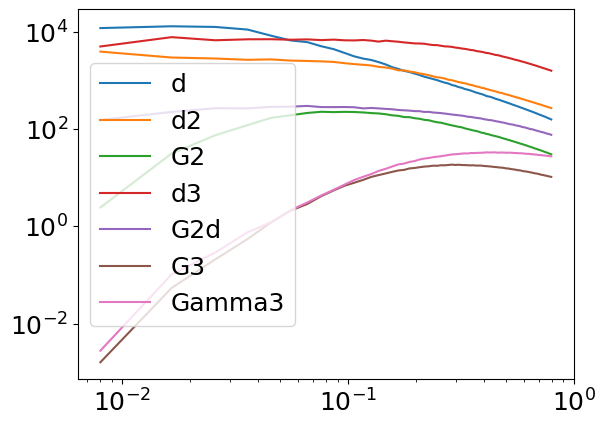

In [34]:
i_mu = 0

k_arr, pks_auto_ortho, Nmodes = PT_field.compute_pks_2d(orthogonalized_fields, 
                                                        mu_edges, 
                                                        measure_pk=measure_pk_E)

for i_field in range(len(orthogonalized_fields)):
    field = idx_to_ortho_fields[i_field]
    plt.plot(k_arr, pks_auto_ortho[i_field,:,i_mu], label=f'{field}')

plt.legend()
plt.xscale('log')
plt.yscale('log')

### Load halos

In [11]:
halos = {}

snap = 2

for snap in [snap]:
    halos[snap] = np.loadtxt(root_data + f'/{seed}/nbody_gadget4/rockstar/out_parents_{snap}.list')

mass_min = 1e12
mass_max = 1e13
mass_idx = np.where((halos[snap][:, 2] >= mass_min) & (halos[snap][:, 2] < mass_max))[0]
pos_x = halos[snap][mass_idx, 8:11].T ### (3, N)

In [12]:
from lss_utils import Mesh_Assignment

mesh = Mesh_Assignment(boxsize, ng=ng_E, window_order=2, interlace=True, dtype=base_dtype)

halo_density = mesh.assign_fft(pos_x)

pk_hh = measure_pk_E(halo_density)

Text(0, 0.5, 'P(k) [h^-3 Mpc^3]')

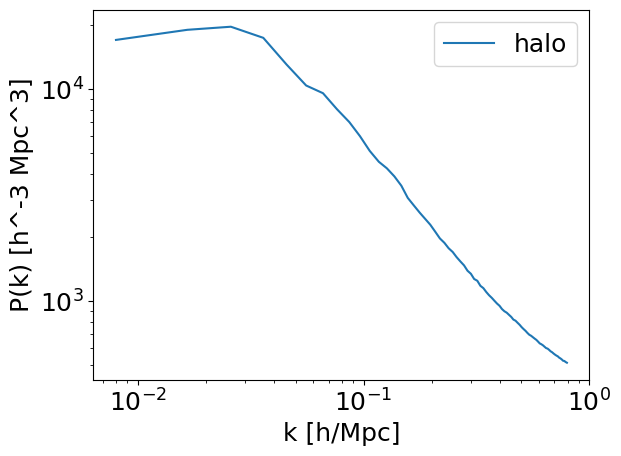

In [35]:
plt.plot(pk_hh[:, 0], pk_hh[:, 1], label=f'halo')

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('k [h/Mpc]')
plt.ylabel('P(k) [h^-3 Mpc^3]')

In [14]:
beta_tab = model.get_beta(halo_density, orthogonalized_fields, 
                          mu_edges, measure_pk=measure_pk_E)

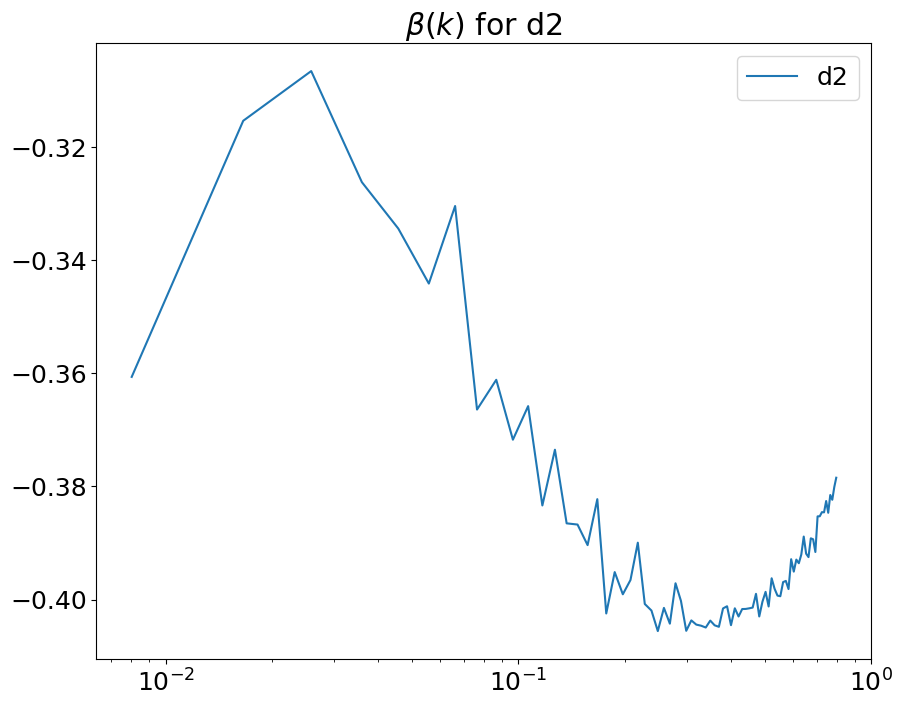

In [38]:
plt.figure(figsize=(10,8))

i_field = 1
field = idx_to_ortho_fields[i_field]

plt.plot(k_arr, beta_tab[i_field,:,i_mu], 
         label=f'{field}')

plt.title(r'$\beta(k)$'+f' for {field}')
plt.legend()
plt.xscale('log')

In [30]:
delta_g_k_linear = model.get_final_field(orthogonalized_fields[0,None],
                                         beta_tab[0,None],
                                         k_edges=k_edges, mu_edges=mu_edges,)

delta_g_k_quad = model.get_final_field(orthogonalized_fields[:3],
                                        beta_tab[:3],
                                        k_edges=k_edges, mu_edges=mu_edges,)


delta_g_k_cubic = model.get_final_field(orthogonalized_fields,
                                        beta_tab,
                                        k_edges=k_edges, mu_edges=mu_edges,)

fields = jnp.stack([halo_density, 
                    delta_g_k_linear, 
                    delta_g_k_quad,
                    delta_g_k_cubic,
                    halo_density - delta_g_k_linear,
                    halo_density - delta_g_k_quad,
                    halo_density - delta_g_k_cubic,
                    ], 
                   axis=0)

idx_to_PT_fields = {0:'hh', 1:'linear', 2:'quad', 3:'cubic',
                    4:'err; linear', 5:'err; quad', 6:'err; cubic'}

k_arr, pks_auto_PT, Nmodes = PT_field.compute_pks_2d(fields, mu_edges, measure_pk=measure_pk_E)


Text(0, 0.5, '$P(k,\\mu)\\ [(\\mathrm{Mpc}/h)^3]$')

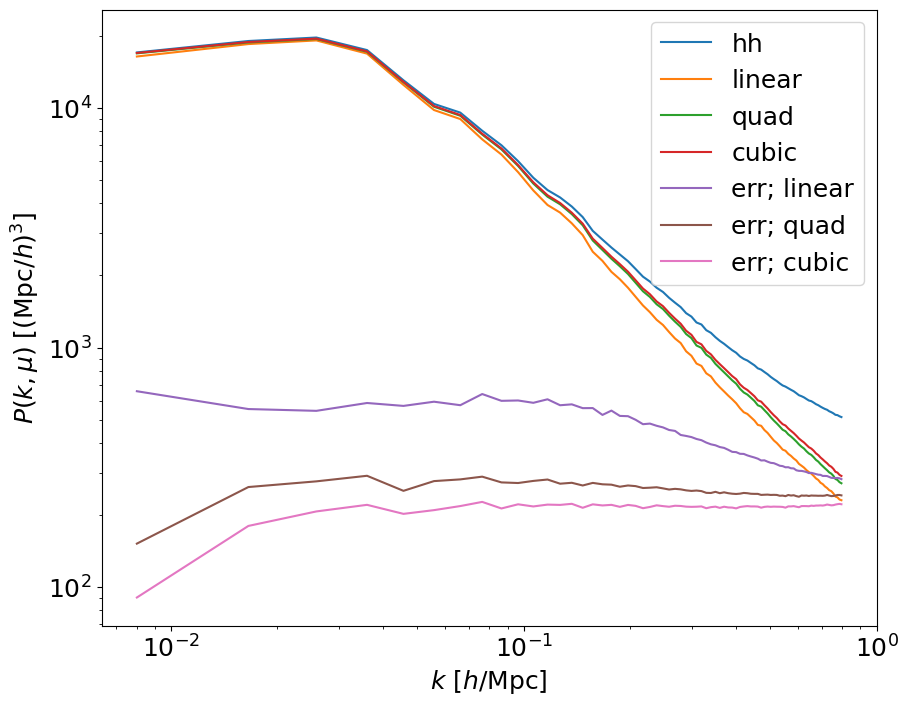

In [39]:
plt.rcParams["font.size"] = 18
plt.figure(figsize=(10,8))
i_mu = 0

for i_field in range(len(fields)):
    field = idx_to_PT_fields[i_field]
    plt.plot(k_arr, pks_auto_PT[i_field,:,i_mu], label=f'{field}')

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k\ [h/\mathrm{Mpc}]$')
plt.ylabel(r'$P(k,\mu)\ [(\mathrm{Mpc}/h)^3]$')